# Fitting quasi-normal modes in A17A17q100d17p000

We begin with some standard imports and global settings.

## Preliminaries

Things we are playing with:
- Analysis duration (0.2-0.6)
- Cutoff time (6 or 10.5 tMf)

- mass, luminosity dist (other file)
- m-range for prior - adapt based on other params to get appropriate range

In [1]:
%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# these are just some standard setup
# must edit to do GPU though - see tip below

# disable numpy multithreading to avoid conflicts (this is for jax on cpu I think)
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", False)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

# import papermill and scrapbook for pipeline
import papermill as pm
import scrapbook as sb
from pathlib import Path

In [3]:
plt.close('all')

From here on we might need to have a loop over each of the taper fcns

In [ ]:
# SETTINGS
num_modes = 2  # number of modes to use in ringdown model
analysis_start_time = 6 #in tMf
output_file = 'fitresults/fit_result.nc' 

duration = 0.2 #0.6 is what the paper used for ringdown, but 0.2 should be enough


In [ ]:
import pandas as pd
from ringdown.data import Data

if num_modes == 1:
    fit = rd.Fit(modes=[(1, -2, 2, 2, 0)])
elif num_modes == 2:
    fit = rd.Fit(modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
else:
    raise ValueError("num_modes must be 1 or 2")

df = pd.read_csv('./bilby_outputs/injection_data.csv')
md = pd.read_csv('./bilby_outputs/injection_metadata.csv')

# geocenter time and sky position from paper
t_geocent_paper = 1420878141.235932  # from Table II
t_h1_paper = 1420878141.2190118  # from Table II
ra = md['ra'].values[0]  
dec = md['dec'].values[0]  
psi = md['psi'].values[0]  

# Shift  data so peak aligns with H1 paper time
t_peak_relative = md['h1_peak_time_offset'].values[0]  # where peak is in our relative time array
time_shift = t_h1_paper - t_peak_relative
df['time'] = df['time'] + time_shift


# we read in the data from csv and add to fit
h1_series = pd.Series(df[f'H1'].values, index=df['time'].values)
fit.add_data(h1_series, ifo='H1')
l1_series = pd.Series(df[f'L1'].values, index=df['time'].values)
fit.add_data(l1_series, ifo='L1')

# i might want to adjust the t0 here. 
t_Mf = 0.337e-3
#two modes from 6, one from 10.5
start_offset = analysis_start_time * t_Mf


fit.set_target(
    t0=t_h1_paper + start_offset,
    ra=ra,
    dec=dec,
    psi=psi,
    duration=duration,
    reference_ifo='H1'
)

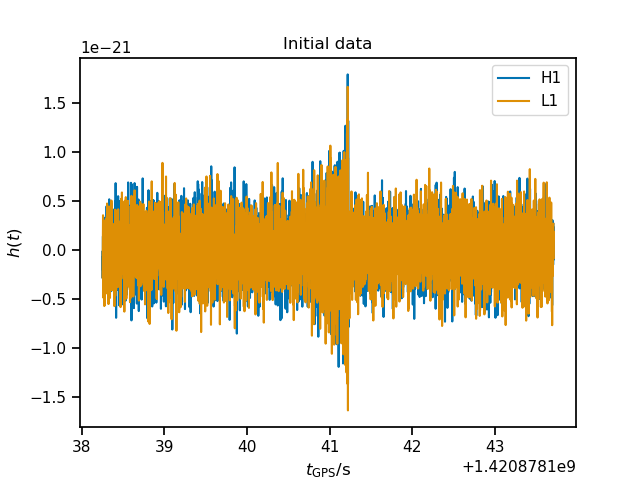

In [6]:
plt.figure()
for ifo, data in fit.data.items():
    data[::4].plot(label=ifo)
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'$h(t)$');
plt.title('Initial data');
plt.legend(loc='best');
plt.show()

Here are estimated noise PSDs for our data:

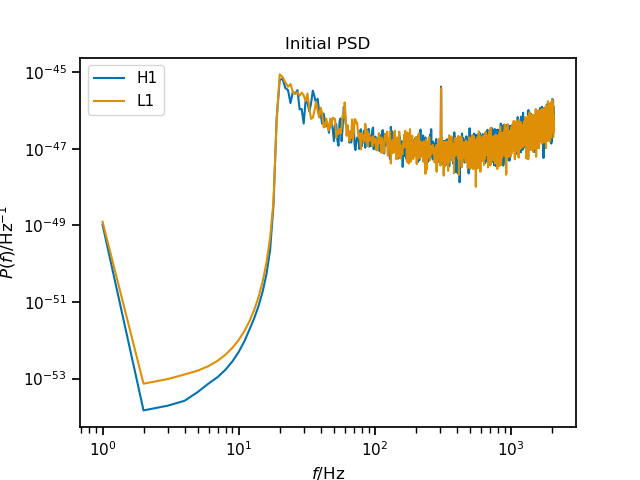

In [7]:
#recall that ASD = sqrt(PSD) - we have already plotted ASD for our sim data, so should be able to compare later
plt.figure()
for ifo, data in fit.data.items():
    plt.loglog(data.get_psd().iloc[1:], label=ifo)
plt.xlabel(r'$f / \mathrm{Hz}$');
plt.ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
plt.title('Initial PSD');
plt.legend(loc='best');
plt.show()

#### Data conditioning

We condition the data - downsample by factor of 8 and set the f_min

#TODO:
Come back and adjust f_min to be the f_1 from the tapering. Need to keep track of it in an object somehow

In [8]:
fit.condition_data(ds=1, f_min=md['f_min'].values[0])
# already have the frequency that the paper had post conditioning

<div class="alert alert-info">

Warning

The conditioning function has a large number of options to manipulate the data in several ways. You should always make sure that the defaults make sense for your data!

</div>

We can visualize the segment of conditioned analysis data as another sanity check:

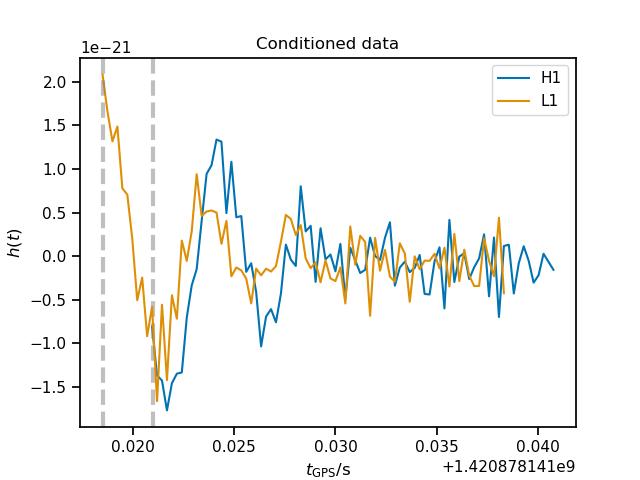

In [9]:
# plot conditioned data
plt.figure()
for i, d in fit.analysis_data.items():
    d.plot(label=i)
    plt.axvline(fit.start_times[i], ls='--', alpha=0.5, lw=3, c='gray')
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'$h(t)$');
plt.title('Conditioned data');
plt.legend(loc='best');
plt.show()

The wave arrived first at Livingston, then at Hanford, which is why the time segments are not exactly aligned.

#### Autocovariance function

A key ingredient in our likelihood calculation is the autocovariance function (ACF) of the noise, which is the time-domain equivalent of the power spectral density (PSD). You can load estimates of the ACF from disk, derive it from a PSD, or estimate it directly from the data. We do the latter below, with some default options.

In [10]:
fit.compute_acfs(f_min=md['f_min'].values[0])

We can use the ACFs to whiten the analysis data and plot it once again.

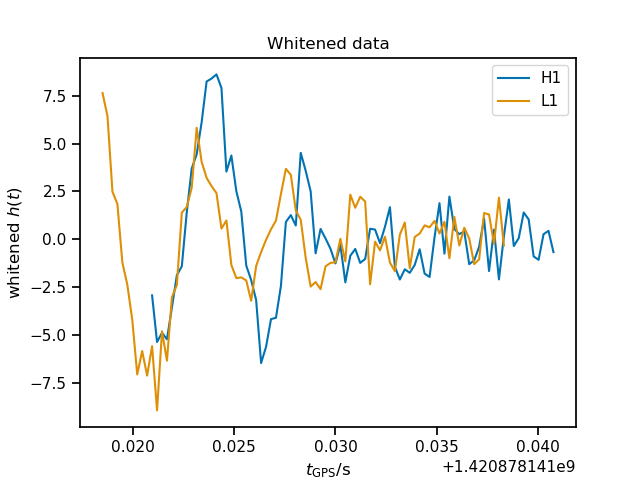

In [11]:
plt.figure()
wd = fit.whiten(fit.analysis_data)
for i, d in wd.items():
    d.plot(label=i)
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'whitened $h(t)$');
plt.title('Whitened data');
plt.legend(loc='best');
plt.show()

The signal is visible towards the beginning of the whitened data.

### Run fit

We are almost ready to run the fit. Before sampling over the posterior on modes, we need to set up some priors with reasonable choices. We can see all the options available by using querying the `valid_model_settings` argument.

In [12]:
print(fit.valid_model_settings)

['a_scale_max', 'marginalized', 'm_min', 'm_max', 'chi_min', 'chi_max', 'cosi_min', 'cosi_max', 'cosi', 'df_min', 'df_max', 'dg_min', 'dg_max', 'f_min', 'f_max', 'g_min', 'g_max', 'flat_amplitude_prior', 'mode_ordering', 'single_polarization']


These settings determine the prior and type of fit. For a vanilla Kerr fit with generic mode polarizations (not parametrized in terms of a source inclination), we only need to specify an amplitude scale, and a mass range.

We are finally ready to run! This should only take a couple of minutes on a modern desktop computer using CPUs.

In [ ]:
# Estimate the peak strain in your analysis window
#peak_strain = max([d.abs().max() for d in fit.analysis_data.values()])
#a_max = 100 * peak_strain

# Set priors/bounds for amplitude scale, mass, spin
# adapt these based on expected values from the simulation
fit.update_model(a_scale_max=5e-20,
                 m_min=50.0,       # Min mass (solar masses)
                 m_max=90.0,      # Max mass (solar masses) 
                 chi_min=0.3,      # Min dimensionless spin
                 chi_max=0.9      # Max dimensionless spin
    )

In [14]:
fit.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
fit.result

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result of our fit is held in `fit.result`. This is just an `arviz.InferenceData` object, with some additional ringdown-specific functionality. As such we can use all tools in ArViz easily.

In [16]:
# Check available methods
print(dir(fit.result))

['InferenceDataItemsView', 'InferenceDataValuesView', '__abstractmethods__', '__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_attrs', '_config_dict', '_config_object', '_default_label_format', '_df_parameters', '_generate_whitened_residuals', '_group_names', '_groups', '_groups_all', '_groups_warmup', '_imr_result', '_is_protocol', '_modes', '_repr_html_', '_target', '_whitened_templates', '_wrap_xarray_method', 'a_scale_max', 'add_groups', 'amplitude_significance', 'analysis_data', '

In [ ]:
# store the fit.result object in a json
# if the output file does not exist, create it
output = Path(output_file).with_suffix('.nc')  # Use .nc extension
output.parent.mkdir(exist_ok=True)
fit.result.to_netcdf(output)

PosixPath('fitresults/fit_result.nc')